In [1]:
from dataset_creation import TextDataset
from torch.utils.data import DataLoader
import numpy as np

# Instantiate the dataset
text_dataset = TextDataset(directory='data/SPGC-tokens-2018-07-18/', sequence_length=100)
print(f"Dataset created with {len(text_dataset)} sequences.")

# Create a DataLoader without a sampler
dataloader = DataLoader(text_dataset, batch_size=1)

# Iterate over a few batches and print their contents
for i, (sequences, inputs) in enumerate(dataloader):
    if i >= 2:  # Adjust this value to see more/less batches
        break

    print(f"\nBatch {i+1}")
    print(f"Inputs shape: {inputs.shape}")

    # Optionally print the actual sequences (comment out if too verbose)
    sequence = ''.join([text_dataset.idx_to_char[int(idx)] for idx in inputs[0]])
    # target = text_dataset.idx_to_char[int(targets[0])]
    print(f"Sequence: {sequence}")


Dataset created with 18422222637 sequences.

Batch 1
Inputs shape: torch.Size([1, 100])
Sequence:  into the chamber and stood by while my mother and mam chloe set me to rights the shock of the fall 

Batch 2
Inputs shape: torch.Size([1, 100])
Sequence: n them over night and did not shrivel up it there old fellow if you really know how to get it out co


In [2]:
import torch

# Define chars using keys of char_to_idx
chars = list(text_dataset.char_to_idx.keys())

n_characters = len(chars)  # Number of unique characters
print(f"Number of unique characters: {n_characters}")
print(f"Characters: {chars}")

Number of unique characters: 70
Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', '.', ';', "'", '"', '?', '!', ' ']


In [3]:
import torch.nn as nn

class HebbianLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(HebbianLinear, self).__init__(in_features, out_features, bias)
        self.imprints = nn.Parameter(torch.zeros_like(self.weight))

    def forward(self, input):
        # print(input)
        output = super(HebbianLinear, self).forward(input)
        self.update_imprints(input, output)
        # print(output)
        return output

    def update_imprints(self, input, output):
        # print("input shape:", input.shape)
        # print("output shape:", output.shape)
    
        # Hebbian update rule: imprint = input * output
        # Adjusting to compute the required [5, 10] imprint matrix for each batch
        # Reshape input and output for broadcasting
        input_expanded = input.unsqueeze(1)  # Shape: [batch_size, 1, in_features]
        output_expanded = output.unsqueeze(2)  # Shape: [batch_size, out_features, 1]

        # Element-wise multiplication with broadcasting
        # Results in a [batch_size, out_features, in_features] tensor
        imprint_update = output_expanded * input_expanded

        # Sum over the batch dimension to get the final imprint update
        self.imprints.data = imprint_update.sum(dim=0)



    def apply_imprints(self, reward, learning_rate):
        # Apply the imprints to the weights
        self.weight.data += reward * learning_rate * self.imprints


# Example instantiation of HebbianLinear
layer = HebbianLinear(in_features=10, out_features=5)

# Checking if the shapes are the same
print("Shape of weights:", layer.weight.shape)
print("Shape of imprints:", layer.imprints.shape)
print("Are the shapes identical?", layer.weight.shape == layer.imprints.shape)

# Generate random data
input_data = torch.randn(3, 10)  # Batch size of 3, input features 10

# Pass data through the HebbianLinear layer
output = layer(input_data)

print("Weights:\n ", layer.weight)
layer.apply_imprints(reward=0.5, learning_rate=0.1)
print("Weights after imprint:\n ", layer.weight)

Shape of weights: torch.Size([5, 10])
Shape of imprints: torch.Size([5, 10])
Are the shapes identical? True
Weights:
  Parameter containing:
tensor([[-0.2317,  0.2773, -0.0810, -0.1681,  0.0625, -0.1055, -0.1074, -0.2497,
          0.2234, -0.2227],
        [ 0.1020,  0.0805,  0.2656, -0.1291, -0.2024, -0.2484, -0.0457,  0.0542,
         -0.1675, -0.1818],
        [-0.1856,  0.1497, -0.2897,  0.1193,  0.2371,  0.2456, -0.0593, -0.2473,
          0.2561,  0.1783],
        [-0.3032,  0.1707, -0.0035,  0.1332, -0.2626,  0.1022, -0.1617, -0.2111,
          0.0551, -0.2138],
        [ 0.0610,  0.2560, -0.0933,  0.2714, -0.0707,  0.2017, -0.1600,  0.1062,
          0.2489, -0.2008]], requires_grad=True)
Weights after imprint:
  Parameter containing:
tensor([[-0.2311,  0.2964, -0.0747, -0.1792,  0.0866, -0.0819, -0.1563, -0.2566,
          0.2412, -0.1995],
        [ 0.1538,  0.0234,  0.2810, -0.2604, -0.2162, -0.3282,  0.0329, -0.0401,
         -0.3002, -0.2429],
        [-0.2291,  0.2492, -

In [4]:
import torch.nn.functional as F

class SimpleRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Using HebbianLinear instead of Linear
        self.linear_layers = torch.nn.ModuleList([HebbianLinear(input_size + hidden_size, hidden_size)])
        for _ in range(1, num_layers):
            self.linear_layers.append(HebbianLinear(hidden_size, hidden_size))

        # Final layers for hidden and output, also using HebbianLinear
        self.i2h = HebbianLinear(hidden_size, hidden_size)
        self.i2o = HebbianLinear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)

        # Pass through the Hebbian linear layers with ReLU
        for layer in self.linear_layers:
            combined = layer(combined)
            combined = F.relu(combined)

        # Split into hidden and output
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def apply_imprints(self, reward, learning_rate):
        # Apply imprints for all HebbianLinear layers
        for layer in self.linear_layers:
            layer.apply_imprints(reward, learning_rate)
        self.i2h.apply_imprints(reward, learning_rate)
        self.i2o.apply_imprints(reward, learning_rate)


# Ensure the input size matches the number of features for each input
input_size = n_characters
output_size = n_characters
n_hidden = 128
rnn = SimpleRNN(input_size, n_hidden, output_size,3)

# Define the loss function (criterion) and optimizer
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)



# Apply Clipping
def clip_weights(model, max_norm):
    with torch.no_grad():
        for param in model.parameters():
            param.data.clamp_(-max_norm, max_norm)

# In your training loop, after the weight update step
clip_weights(rnn, max_norm=0.5)  # Choose an appropriate max_norm value


In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return text_dataset.char_to_idx[letter]

# Just for demonstration, turn a letter into a <1 x n_characters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_characters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_characters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_characters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([5, 1, 70])


In [6]:
text_dataset[3]

('lt and i was sure something had happened she explained to her husband who still stood by her strokin',
 tensor([11, 19, 69,  0, 13,  3, 69,  8, 69, 22,  0, 18, 69, 18, 20, 17,  4, 69,
         18, 14, 12,  4, 19,  7,  8, 13,  6, 69,  7,  0,  3, 69,  7,  0, 15, 15,
          4, 13,  4,  3, 69, 18,  7,  4, 69,  4, 23, 15, 11,  0,  8, 13,  4,  3,
         69, 19, 14, 69,  7,  4, 17, 69,  7, 20, 18,  1,  0, 13,  3, 69, 22,  7,
         14, 69, 18, 19,  8, 11, 11, 69, 18, 19, 14, 14,  3, 69,  1, 24, 69,  7,
          4, 17, 69, 18, 19, 17, 14, 10,  8, 13]))

In [7]:
def randomTrainingExample():
    """Generate a random training example from the dataset"""
    sequence, line_tensor = text_dataset[np.random.randint(len(text_dataset))]
    return sequence, line_tensor

randomTrainingExample()

('ä sanonpa yhden asian teille molemmille lisäksi sanoi tyttö ja nosti hihansa kainaloon asti sanon te',
 tensor([ 0, 69, 18,  0, 13, 14, 13, 15,  0, 69, 24,  7,  3,  4, 13, 69,  0, 18,
          8,  0, 13, 69, 19,  4,  8, 11, 11,  4, 69, 12, 14, 11,  4, 12, 12,  8,
         11, 11,  4, 69, 11,  8, 18,  0, 10, 18,  8, 69, 18,  0, 13, 14,  8, 69,
         19, 24, 19, 19,  0, 69,  9,  0, 69, 13, 14, 18, 19,  8, 69,  7,  8,  7,
          0, 13, 18,  0, 69, 10,  0,  8, 13,  0, 11, 14, 14, 13, 69,  0, 18, 19,
          8, 69, 18,  0, 13, 14, 13, 69, 19,  4]))

In [8]:
learning_rate = 0.0005 # If you set this too high, it might explode. If too low, it might not learn

def train(line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0] - 1):
        hot_input_char_tensor = torch.nn.functional.one_hot(line_tensor[i], num_classes=n_characters).type(torch.float).unsqueeze(0)
        output, hidden = rnn(hot_input_char_tensor, hidden)

    # print("output shape:", output.shape)
    # print("line_tensor shape:", line_tensor.shape)
    # print(output)
    loss = criterion(output, line_tensor[-1].unsqueeze(0))
    # print(loss)

    # Convert loss to a reward signal
    reward = 1 / (1 + loss.item())  # Example conversion, assuming loss is non-negative
    # print(reward)
    
    clip_weights(rnn, max_norm=0.5)  # Choose an appropriate max_norm value

    # Apply Hebbian updates
    rnn.apply_imprints(reward, learning_rate)

    # Perform backward pass and optimizer step if using gradient descent for other parameters
    # loss.backward()
    # optimizer.step()

    return output, loss.item()


In [9]:
import time
import math

n_iters = 100000
print_every = 50
plot_every = 10



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    sequence, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        # Use the output to generate a character prediction
        topv, topi = output.topk(1, dim=1)  # Change dim to 1
        predicted_char = text_dataset.idx_to_char[topi[0, 0].item()]
        target_char = sequence[-1]
        correct = '✓' if predicted_char == target_char else '✗ (%s)' % target_char
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, sequence, predicted_char, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

50 0% (0m 1s) 4.2745 ave me a thought that is i wonder if you give me a thought i m not a good woman i don t mean i m not / Y ✗ (t)
100 0% (0m 3s) 4.1976 suuresti tätä hänen hyvää päätöstään koska näet uskoi aivan todeksi mitä rouva oli sanonut ja hän lu / 6 ✗ (u)
150 0% (0m 4s) 4.2653 fence they were in favor of every measure which led to war while they were irritating a nation to wa / Y ✗ (a)
200 0% (0m 6s) 4.1921 rth where i saw marshal ney and i afterwards rejoined the emperor at munich there i had the pleasure / Y ✗ (e)
250 0% (0m 8s) 4.2671 at a notice that true said the other we do want the police you do replied voles he was staring at jo / Y ✗ (o)
300 0% (0m 9s) 4.1461 fect happiness they after the broke up there was a ball numerously attended where there was a prodig / Y ✗ (g)
350 0% (0m 11s) 4.1984 me miracle pendant que pénétrait pour la première fois dans le corps de ces petits le céleste le sou / Y ✗ (u)
400 0% (0m 12s) 4.3064 e mass of being abolished it was nevertheless 

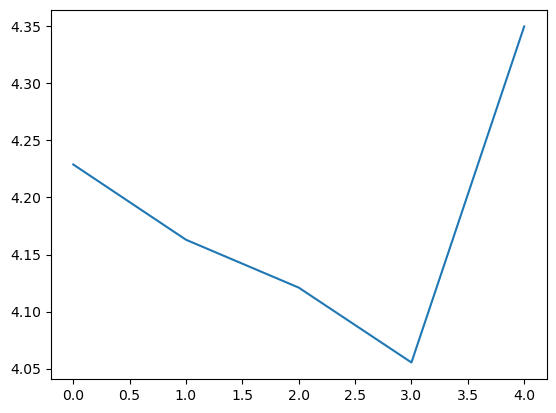

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)